# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [4]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

## Download Model

In [5]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [6]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [7]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [12]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [77]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '~/dev/Advanced_Image_Analysis_02503/Final_Project/vid_data/images_test'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]
#TEST_IMAGE_PATHS = []
#TEST_IMAGE_PATHS.append('test_images/vid3_045.png')
# Size, in inches, of the output images.
IMAGE_SIZE = (16, 12)

In [87]:
import glob
glob.glob("~/dev/Advanced_Image_Analysis_02503/Final_Project/vid_data/images_test/*")

[]

In [18]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

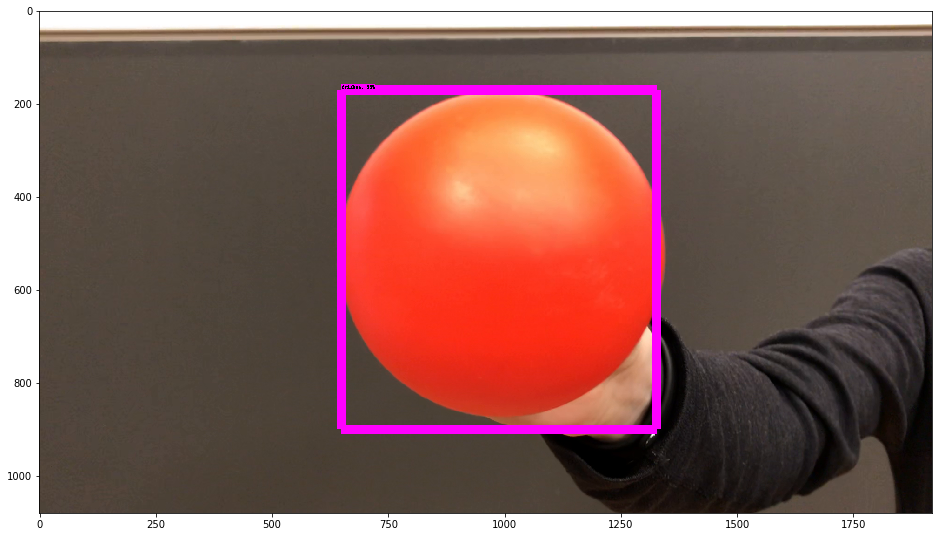

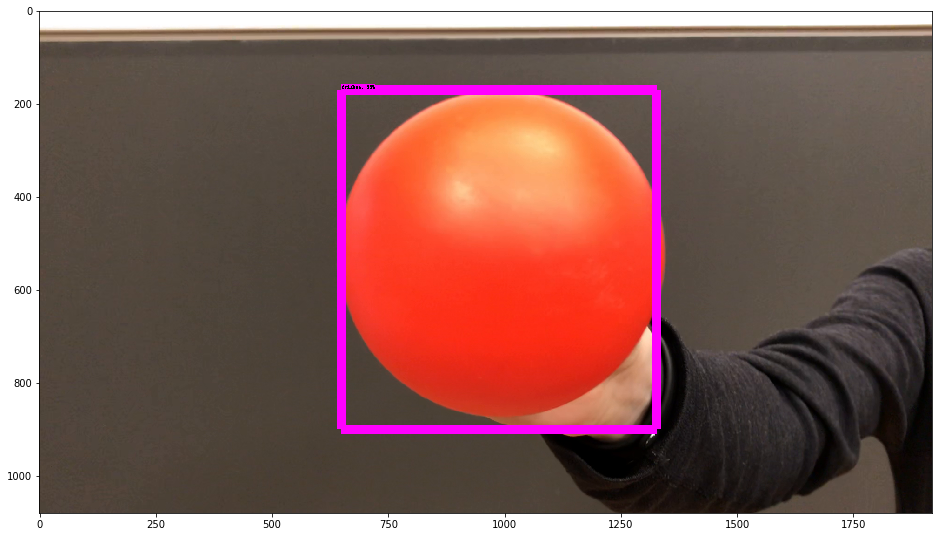

In [30]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=20)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

In [45]:
output_dict['detection_boxes'][0][3]*1920

1327.7946853637695

In [49]:
output_dict['detection_classes']

array([34,  1, 34,  1, 37,  1, 53,  1, 34, 47, 62,  1,  1,  1, 62, 62, 62,
        1, 81,  1,  1, 81,  1, 86, 51,  1, 62, 62, 62,  1, 32,  1, 34, 62,
       81,  1, 62, 81, 85, 81,  1,  1, 81, 81,  1,  1, 34, 67, 34, 32, 62,
       62, 81, 81, 32, 62, 62, 62,  1, 62, 62, 34, 34, 62, 81, 62,  1,  1,
       81, 62, 81, 62, 62, 62, 84, 84,  1, 84, 62,  1, 81, 62, 55, 81, 62,
        1,  1,  1, 62,  1,  1, 81, 42, 84, 62, 84,  1, 62,  1,  1], dtype=uint8)

In [76]:
for i, cat in enumerate(output_dict['detection_classes']):
    print(output_dict['detection_scores'][i], end = " ")
    print(category_index[cat]['name'])

0.951762 frisbee
0.420129 person
0.200164 frisbee
0.189259 person
0.12587 sports ball
0.0997277 person
0.0862492 apple
0.0795399 person
0.0721101 frisbee
0.06587 cup
0.0581129 chair
0.057001 person
0.0507305 person
0.0503867 person
0.0496824 chair
0.04752 chair
0.0467576 chair
0.0463696 person
0.045816 sink
0.0452359 person
0.0447361 person
0.0441802 sink
0.0436258 person
0.0433564 vase
0.0428949 bowl
0.0409751 person
0.0405233 chair
0.0398408 chair
0.0373175 chair
0.0366501 person
0.0357721 tie
0.0353168 person
0.0335774 frisbee
0.0333515 chair
0.0328101 sink
0.0320347 person
0.0314219 chair
0.0313701 sink
0.0313023 clock
0.030464 sink
0.0300103 person
0.0299765 person
0.0294114 sink
0.0290988 sink
0.0287311 person
0.0286403 person
0.0279609 frisbee
0.0271532 dining table
0.0270808 frisbee
0.0267237 tie
0.0266252 chair
0.0263785 chair
0.026305 sink
0.0262055 sink
0.0257801 tie
0.0257329 chair
0.0255784 chair
0.0253545 chair
0.0249769 person
0.0247358 chair
0.0244131 chair
0.0243052 fr

In [59]:
category_index[output_dict['detection_classes'][0]]['name']

'frisbee'

In [61]:
output_dict['detection_classes']

array([34,  1, 34,  1, 37,  1, 53,  1, 34, 47, 62,  1,  1,  1, 62, 62, 62,
        1, 81,  1,  1, 81,  1, 86, 51,  1, 62, 62, 62,  1, 32,  1, 34, 62,
       81,  1, 62, 81, 85, 81,  1,  1, 81, 81,  1,  1, 34, 67, 34, 32, 62,
       62, 81, 81, 32, 62, 62, 62,  1, 62, 62, 34, 34, 62, 81, 62,  1,  1,
       81, 62, 81, 62, 62, 62, 84, 84,  1, 84, 62,  1, 81, 62, 55, 81, 62,
        1,  1,  1, 62,  1,  1, 81, 42, 84, 62, 84,  1, 62,  1,  1], dtype=uint8)

In [72]:
output_dict['detection_scores']

array([ 0.95176172,  0.42012906,  0.20016368,  0.18925942,  0.12586974,
        0.09972767,  0.08624925,  0.07953989,  0.07211013,  0.06586997,
        0.05811285,  0.05700102,  0.05073052,  0.05038674,  0.04968242,
        0.04751997,  0.04675762,  0.04636963,  0.045816  ,  0.04523592,
        0.04473612,  0.04418018,  0.04362579,  0.04335643,  0.04289486,
        0.04097508,  0.04052332,  0.0398408 ,  0.03731751,  0.03665005,
        0.03577209,  0.03531685,  0.03357736,  0.03335151,  0.03281011,
        0.03203473,  0.03142189,  0.03137012,  0.03130227,  0.03046402,
        0.03001026,  0.02997652,  0.02941144,  0.02909883,  0.0287311 ,
        0.02864034,  0.02796089,  0.02715321,  0.02708078,  0.02672373,
        0.02662517,  0.02637846,  0.026305  ,  0.0262055 ,  0.02578011,
        0.02573293,  0.02557844,  0.02535446,  0.02497692,  0.02473575,
        0.02441311,  0.02430523,  0.02412098,  0.02372508,  0.02370283,
        0.02369947,  0.02367568,  0.02362231,  0.02360877,  0.02